# Outline
0. Create ground truth distribution and get samples
1. Parameterized models and maximum likelihood estimation
2. Calculate fourier coefficients

# 0. Ground Truth Distribution

In [19]:
from enum import Enum
class SamplingType(Enum):
    # RANDOM = 1
    # GRID = 2
    SAMPLING = 3


def gaussian_casadi_normalized(x, center, std, n=2):
    return casadi.exp(-1/2 * casadi.sum2((x - center)**2)/std)/(2*np.pi*std) # casadi.sqrt((2*np.pi*std)**n)

def gaussian_normalized(x, center, std, n=2):
    return np.exp(-1/2 * np.sum((x - center)**2)/std)/np.sqrt((2*np.pi*std)**n)


def gaussian_modes(n, num_modes, gaussian=gaussian_casadi_normalized):
    num_params = (n+1)*num_modes
    def model(x, params):
        total = 0
        for i in range(num_modes):
            center = params[i,:-1]
            std = params[i,-1]
            total += gaussian(x, center, std) 
        return total
    
    return (num_modes, n+1), model, f"{n}_mode_gaussian"

In [20]:
U_shape = (1,1)

from probability_distribution import *

x = np.array([0.5,0.5])
# params = np.array([[0.35, 0.75, 0.01], [0.7, 0.4, 0.01]]) # twin peaks
params = np.array([[0.25, 0.75, 0.025], [0.5, 0.5, 0.025]])
# _,model,_ = gaussian_modes(2,2,gaussian=gaussian_normalized)
# mu_unnorm = lambda x: model(x, params)
mu_unnorm = mu_gaussians([(np.array([0.25, 0.75]), 0.025), (np.array([0.5, 0.5]), 0.025)], U_shape)
total = mu_total(mu_unnorm, U_shape)
mu = lambda x: mu_unnorm(x)/total

In [21]:
ground_truth = mu
distribution_name = "close_peaks"#"twin_peaks"
s_type = SamplingType.SAMPLING    
K = 5
mu_display2D(ground_truth, U_shape, f"maximum_likelihood_estimation/{distribution_name}_ground_truth")

In [22]:
from fourier_functions import *

ff = Fourier_Functions(ground_truth, U_shape, K, compute_mu=True)
ground_truth_mu_k = {k: ff[k]['mu_k'] for k in ff}


In [23]:
resolution = 500
alpha = 100 # approx how many points?
import random 

sample_x = []
sample_y = []
sample_points = []
for x in np.linspace(0, 1, resolution+1):
    for y in np.linspace(0, 1, resolution+1):
        point = np.array([x,y])
        if random.random() < ground_truth(point)*(1/resolution)**2*alpha:
            sample_x.append(x)
            sample_y.append(y)
            sample_points.append(point)

sample_values = [ground_truth(x) for x in sample_points]

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

assert len(U_shape) == 2
X,Y = np.meshgrid(*[np.linspace(0,U_shape[i]) for i in range(2)])
_s = np.stack([X.ravel(), Y.ravel()]).T

plt.title("Ground Truth and Sampling")
ax.contourf(X,Y, np.array(list(map(mu, _s))).reshape(X.shape), cmap='binary')
ax.scatter(sample_x, sample_y)
ax.set_aspect('equal')
plt.axis('off')
plt.savefig(f"maximum_likelihood_estimation/{distribution_name}_ground_truth_sampling.pdf")
plt.close("all")

# 1. Parameterized models and maximum likelihood estimation

In [25]:
# model(x, args*)
# models = [gaussian_modes(2,num_modes,gaussian=gaussian_casadi_normalized) for num_modes in range(1, 6)]


In [26]:
# import casadi
# import pickle
# from fourier_functions import *

# full_models = []


# def pdf_likelihood(params, model, sample_points):
#     # integral = 0
#     # for x in np.linspace(0, 1, resolution+1):
#     #     for y in np.linspace(0, 1, resolution+1):
#     #         integral += model(casadi.DM([[x,y]]), params)/resolution**2
#     l = 1
#     for x in sample_points:
#         l *= model(casadi.DM(x.reshape((1,2))), params)# /integral
#     return l

# def function_distance(params, model, sample_points, sample_values):
#     l = 0 
#     for i, x in enumerate(sample_points):
#         l += abs(sample_values[i] - model(x, params))
#     return l

# for num_args, model, model_name in models:
#     print(f"Model: {model_name}")
#     c_opti = casadi.Opti()
#     params = c_opti.variable(num_args[0],num_args[1])
#     num_modes, _ = num_args
#     for i in range(num_modes):
#         c_opti.subject_to( params[i,-1] > 1e-5 )
#         c_opti.subject_to( params[i,:-1] >= 0 )
#         c_opti.subject_to( params[i,:-1] <= np.array(U_shape).reshape(1,-1) )
#     c_opti.minimize(-pdf_likelihood(params, model, sample_points))
#     # c_opti.minimize(function_distance(params, model, sample_points, sample_values))

#     p_opts = {}
#     s_opts = {'print_level': 0}
#     c_opti.solver('ipopt', p_opts, s_opts)
#     params_sol = c_opti.solve() 
    
#     mu = lambda x: model(x, params_sol)
#     mu_display2D(mu, U_shape, f"maximum_likelihood_estimation/{distribution_name}_{model_name}")
#     ff = Fourier_Functions(mu, U_shape, K, compute_mu=True)
#     mu_k = {k: ff[k]['mu_k'] for k in ff}
#     full_models.append((params_sol, mu, mu_k))

#     with open(f'maximum_likelihood_estimation/{distribution_name}_{model_name}_{K}.pkl', 'wb') as handle:
#         pickle.dump(mu_k, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [27]:
# plt.figure()
# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0, 1, len(ff)))
# ks = [k for k in ff]

# for i, (k, color) in enumerate(zip(ks, colors), 1):
#     plt.plot(perturbation_amts, [abs(perturbation[p_amt]["c_k"][k]-agent1.c_k[k]) for p_amt in perturbation_amts], "o", label=str(k), color=color)
#     plt.plot(perturbation_amts, [min([p_amt/ff[k]["h_k"]*2*max(k), 2/ff[k]["h_k"]]) for p_amt in perturbation_amts], "-", color=color)
# plt.xlabel("Maximum Perturbation Amount")
# plt.ylabel("c_k perturbation amount")
# plt.savefig(f"perturbations/{distribution_name}_trajectory_perturbation_vs_c_k_perturbation.pdf")
# plt.close()

# plt.figure()
# for i, (k, color) in enumerate(zip(ks, colors), 1):
#     plt.plot(perturbation_amts, [abs(perturbation[p_amt]["c_k"][k]-agent1.c_k[k]) for p_amt in perturbation_amts], "o-", label=str(k), color=color)
# plt.xlabel("Maximum Perturbation Amount")
# plt.ylabel("c_k perturbation amount")
# plt.savefig(f"perturbations/{distribution_name}_trajectory_perturbation_vs_c_k_perturbation_alone.pdf")
# plt.close()

---------------------------------------------------------------------------------------------------

In [28]:
mean = np.mean(sample_points,axis=0).reshape(2,1)
cov = (1/len(sample_points))*sum([(x.reshape(2,1)-mean)@(x.reshape(2,1)-mean).T for x in sample_points])
print(mean)
print(cov)
print(np.linalg.inv(cov))
print(np.linalg.det(cov))

[[0.41083019]
 [0.61601887]]
[[ 0.02696467 -0.01301885]
 [-0.01301885  0.02261981]]
[[51.3566773  29.55836662]
 [29.55836662 61.2213701 ]]
0.0004404453744460196


In [29]:
def one_mode(samples):
    mean = np.mean(np.array(samples),axis=0)
    std = np.sqrt(np.mean(np.array([np.linalg.norm(x-mean)**2 for x in samples])))
    def res(x):
        return np.exp(-1/2 * np.sum((x - mean)**2)/std)/np.sqrt((2*np.pi*std)**2)
    return res

def multivariate_gaussian(samples):
    mean = np.mean(samples,axis=0).reshape(2,1)
    cov = (1/len(samples))*sum([(x.reshape(2,1)-mean)@(x.reshape(2,1)-mean).T for x in samples])
    invcov = np.linalg.inv(cov)
    def res(x):
        return np.exp(-1/2 * np.sum((x.reshape(2,1) - mean).T@invcov@(x.reshape(2,1) - mean)))
    return res


wrong_model = mu_normalize(multivariate_gaussian(sample_points), U_shape)
wrong_model_name = "unimodal"
mu_display2D(wrong_model, U_shape, f"maximum_likelihood_estimation/{distribution_name}_{wrong_model_name}")




In [30]:
ff = Fourier_Functions(wrong_model, U_shape, K, compute_mu=True)
model_mu_k = {k: ff[k]['mu_k'] for k in ff}

In [31]:
import pickle
with open(f'maximum_likelihood_estimation/{distribution_name}_{wrong_model_name}_{K}.pkl', 'wb') as handle:
    pickle.dump(model_mu_k, handle, protocol=pickle.HIGHEST_PROTOCOL)

fig = plt.figure()
ax = fig.add_subplot(111)

assert len(U_shape) == 2
X,Y = np.meshgrid(*[np.linspace(0,U_shape[i]) for i in range(2)])
_s = np.stack([X.ravel(), Y.ravel()]).T

plt.title("Unimodal with Sampling")
ax.contourf(X,Y, np.array(list(map(wrong_model, _s))).reshape(X.shape), cmap='binary')
ax.scatter(sample_x, sample_y)
ax.set_aspect('equal')
plt.axis('off')
plt.savefig(f"maximum_likelihood_estimation/{distribution_name}_{wrong_model_name}_sampling.pdf")
plt.close("all")

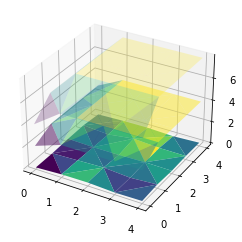

In [32]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
x = []
y = []
z = []

inf_norm = np.max(np.array(list(map(lambda x: abs(wrong_model(x)-ground_truth(x)), _s))).reshape(X.shape))
fourier_diff_bound = []
z_bound = []
for k in model_mu_k:
    x.append(k[0])
    y.append(k[1])
    z.append(abs(model_mu_k[k]-ground_truth_mu_k[k]))
    fourier_diff_bound.append(2/ff[k]["h_k"])
    z_bound.append(inf_norm*1/ff[k]["h_k"])
ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
plt.savefig(f"maximum_likelihood_estimation/{distribution_name}_{wrong_model_name}_error_alone.pdf")
ax.plot_trisurf(x, y, fourier_diff_bound, cmap='viridis', edgecolor='none', alpha=0.5)
plt.savefig(f"maximum_likelihood_estimation/{distribution_name}_{wrong_model_name}_fourier_bound_error.pdf")
ax.plot_trisurf(x, y, z_bound, cmap='viridis', edgecolor='none', alpha=0.25)
plt.savefig(f"maximum_likelihood_estimation/{distribution_name}_{wrong_model_name}_max_error.pdf")

In [33]:
from ergodic_agents import *
from mm_agent import *
from casadi_agent import *
all_k = list(np.ndindex(*[K]*len(U_shape)))
agent1 = CasadiAgent(0, np.array([0.2, 0.3]), 0.5, all_k, U_shape, ff, eps=1e-5)
system1 = AgentSystem([agent1], wrong_model, U_shape, ff, K)
t = 0
delta_t = 0.1
for i in range(100):
    t = i * delta_t
    system1.evolve(t, delta_t)
system1.visualize_trajectory(f"maximum_likelihood_estimation/{distribution_name}_{wrong_model_name}_trajectory.pdf", "")


(2, 100)
(2, 100)
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 139.34ms (  2.68ms) 139.59ms (  2.68ms)        52
       nlp_g  |   3.44ms ( 66.10us)   3.37ms ( 64.90us)        52
  nlp_grad_f  | 239.85ms (  4.80ms) 240.14ms (  4.80ms)        50
  nlp_hess_l  |  98.99 s (  2.06 s)  98.99 s (  2.06 s)        48
   nlp_jac_g  |  44.15ms (882.92us)  44.28ms (885.57us)        50
       total  | 100.91 s (100.91 s) 100.91 s (100.91 s)         1


In [34]:
def ergodic_metric(lambda_k, c_k, mu_k):
    return sum([lambda_k[k]*(mu_k[k] - c_k[k])**2 for k in lambda_k])

_lambda_k = {k: ff[k]['lambda_k'] for k in ff}

print("Ergodicity wrt to unimodal: ", system1.e_log[-1])
print("Ergodicity wrt to ground truth: ", ergodic_metric(_lambda_k, system1.c_k, model_mu_k))

Ergodicity wrt to unimodal:  4.706089553399407e-09
Ergodicity wrt to ground truth:  4.706089553399407e-09
